In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

In [3]:
download_path = "../prototype/pytorch_prototype/data"

trainset = torchvision.datasets.CIFAR10(
    root=download_path,
    train=True,
    download=True,
    transform=transform)

testset = torchvision.datasets.CIFAR10(
    root=download_path,
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import random

# 複数クラスラベルのデータセットから指定クラスラベルの1データセットを取得
def get_one_label_data(class_label, dataset):
    new_data = []
    for data in dataset:
        label = data[1]
        if label == class_label:
            new_data.append(data)
    return new_data

# 複数クラスラベルのデータセットから指定クラスラベルのtrain, testデータセットを取得
def get_one_label_dataset(class_label, train, test):
    train = get_one_label_data(class_label, train)
    test = get_one_label_data(class_label, test)
    return train, test

# 1データセットのラベルを指定のラベルに変更
def change_label_data(new_label, dataset):
    new_data = []
    for data in dataset:
        new_data.append((data[0], new_label))
    return new_data

# train, testデータセットのラベルを指定のラベルに変更
def change_label_dataset(new_label, train, test):
    train = change_label_data(new_label, train)
    test = change_label_data(new_label, test)
    return train, test

# 指定データ数分のtrainデータをランダムに取得
# data_n: 1クラスのデータ数
def choice_train_at_random(data_n, train):
    train = random.sample(train, data_n)
    return train

# 指定クラスラベルリストのtrain, testデータセットを取得
def get_specific_label_dataset(class_label_list, train, test, data_n=None):
    new_train = []
    new_test = []
    for i, label in enumerate(class_label_list):
        got_train, got_test = get_one_label_dataset(label, train, test)
        got_train, got_test = change_label_dataset(i, got_train, got_test)
        if data_n != None:
            got_train = choice_train_at_random(data_n, got_train)
        new_train += got_train
        new_test += got_test
    return new_train, new_test

In [6]:
class_label_list = [1,2,8]
new_train, new_test = get_specific_label_dataset(class_label_list, trainset, testset, 50)

In [7]:
print(len(new_train))
print(len(new_test))

150
3000


In [9]:
batch_size = 5

trainloader = torch.utils.data.DataLoader(
    new_train,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

testloader = torch.utils.data.DataLoader(
    new_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

In [21]:
# feature_df作成

import pandas as pd
from test_assets.model import pytorch_cifar10

classes = ["automobile", "bird", "ship"]
df = pd.DataFrame()
df_data_name = []
df_data = []
df_features = []
df_labels = []

param_path = "./test_assets/learned_model/v8.pth"
param = torch.load(param_path)
model = pytorch_cifar10.LeNet(3)
model.load_state_dict(param)
count = 0

for (inputs, labels) in trainloader:
    outputs, feature = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    for i in range(len(inputs)):
        df_data_name.append("data_" + str(count))
        df_data.append(inputs[i])
        df_features.append(feature[i].data)
        df_labels.append(labels[i].item())
        count += 1

df["data_name"] = df_data_name
df["data"] = df_data
df["feature"] = df_features
df["label"] = df_labels

In [22]:
df

,data_name,data,feature,label
0,data_0,"[[[tensor(0.6706), tensor(0.5137), tensor(0.41...","[tensor(0.4480), tensor(1.0073), tensor(0.1741...",0
1,data_1,"[[[tensor(-0.1608), tensor(-0.1373), tensor(-0...","[tensor(0.0409), tensor(0.5815), tensor(0.), t...",0
2,data_2,"[[[tensor(-0.1451), tensor(-0.0980), tensor(-0...","[tensor(0.5591), tensor(0.9450), tensor(0.2161...",0
3,data_3,"[[[tensor(0.6627), tensor(0.6627), tensor(0.69...","[tensor(0.4898), tensor(0.5856), tensor(0.1126...",0
4,data_4,"[[[tensor(0.0039), tensor(-0.1608), tensor(-0....","[tensor(0.5964), tensor(0.6787), tensor(0.0724...",0
5,data_5,"[[[tensor(-0.6549), tensor(-0.6235), tensor(-0...","[tensor(0.6670), tensor(0.2794), tensor(0.6129...",0
6,data_6,"[[[tensor(0.9451), tensor(0.9137), tensor(0.92...","[tensor(0.2814), tensor(1.3171), tensor(0.2351...",0
7,data_7,"[[[tensor(-0.5137), tensor(-0.5765), tensor(-0...","[tensor(0.6894), tensor(0.8074), tensor(0.1776...",0
8,data_8,"[[[tensor(-0.7098), tensor(-0.5686), tensor(-0...","[tensor(0.2911), tensor(0.5657), tensor(0.), t...",0
9,data_9,"[[[tensor(1.), tensor(1.), tensor(1.), tensor(...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

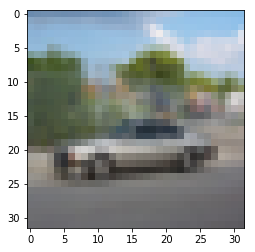

In [30]:
imshow(torchvision.utils.make_grid(df["data"][1]))

In [46]:
# コサイン距離 0が最も似ている, 2が最も離れている
import numpy as np
import scipy.spatial.distance as dis

In [45]:
# コサイン類似度 1が最も似ている, -1が最も離れている
1- dis.cosine(df["feature"][0], df["feature"][1])

0.7762588858604431

In [66]:
# ユークリッド距離
a = np.asarray(df["feature"][0])
b = np.asarray(df["feature"][1])
print(np.sqrt(np.power(a-b, 2).sum()))
print(np.sqrt(((a-b)**2).sum()))

6.0035024
6.0035024


In [68]:
df_add_cosine = df.copy()